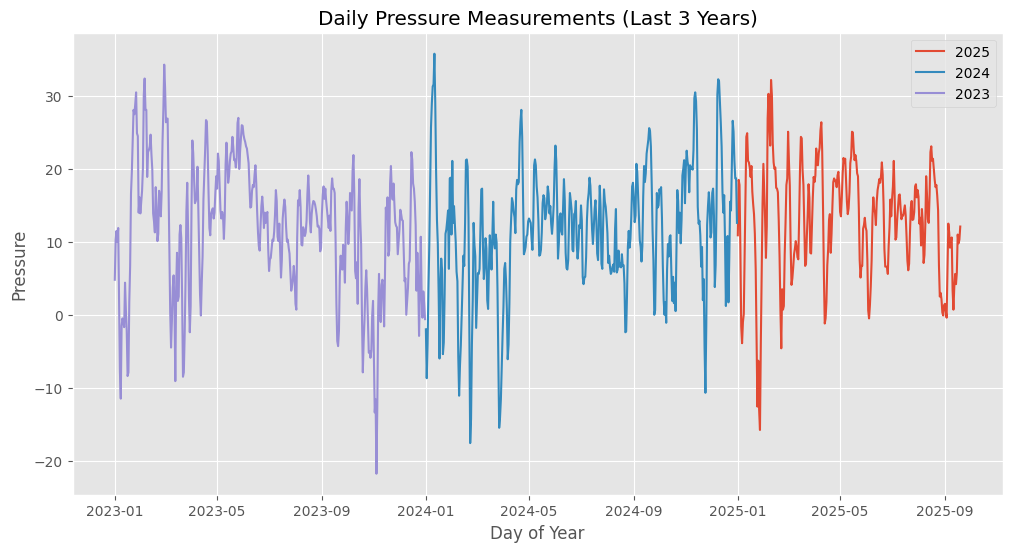

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# First naming the dataset for use in the data analysis
df = pd.read_csv('UK_Centered.csv')
df = df.rename(columns = {' month': 'month', ' year': 'year', ' PM_1000':'PM_1000',
                          ' w':'w',' s': 's', ' f': 'f',' z':'z', ' g':'g', ' dir':'dir', ' LWT': 'LWT'}) # Renaming column name to get rid of odd spaces
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']]) # Creating datetime column for easier data handling
past_three_years = [2025 - i for i in range(3)]

df_recent = df[df["year"].isin(past_three_years)]
plt.figure(figsize=(12,6))

for year in past_three_years:
    yearly_data = df_recent[df_recent["year"] == year]
    plt.plot(yearly_data["datetime"], yearly_data["PM_1000"], label=str(year))  # plotting daily pressure last 3 years



Data appears very chaotic, when the pressure is just plotted against the date-time. Much more analysis required, and handling of the data, in order to examine patterns. Though it potentially looks like the pressure, whilst still very chaotic in the last year, is slightly less chaotic more than than it was in the two years prior.

Graph shows that there haven't been as many cyclonic days before september as we would expect, when compared to data from the last 30 years. Next, new definitions of what actually defines persistence are required. Firstly need to sort the weather types into different categories, as 28 types is simply too many to perform analyses on. Intuitively makes sense to have classifications of Cyclonic, Anti-Cyclonic, and Neither (which would contain all pure wind weather types, and the uncategorised U). After looking at the literature, a potential definition of persistence from De Luca has been found; the conditional probability that given Day(T) has type i, day(T+1) will also have the same type. This would refer mainly to a quasi-static type (from Tuel) of persistence - related to how long storms stay; opposed to a recurrent type of storm. Though these are linked, quasi-static persistence would not give a full description of persistence.

This conditional probabiltity is also pretty linked with Markov chains - could be worthwhile finding out more about that, or even finding a 3x3 transition matrix? Maybe not though, not completely linked.

In [3]:
def categorise(x):
    if 0 <= x <= 8:
        return 'AC'
    elif 20 <= x <= 28:
        return 'C'
    else:
        return 'N'

df['Grouped_LWT'] = df['LWT'].apply(categorise)

Categorise function created to group all the LWTs for future use with persistence functions. Next, we have the functions that give metrics of persistence. Persistence_count and the first element of Total_storms, the average period length give quasi-static metrics. Avg_between and Total_storms give metrics for recurrent persistence which could be analysed.

In [4]:
def persistence_count(df,types):
    ''' calculates the conditional probability that day(t) had grouped weather type i, given day(t+1) had grouped weather type i, for types given.'''
    count_1 = 0
    count_2 = 0
    for v in types:
        for i in range(len(df['Grouped_LWT']) - 1):
            if df['Grouped_LWT'].iloc[i] == v and df['Grouped_LWT'].iloc[i + 1] == v:
                count_1 += 1
            if df['Grouped_LWT'].iloc[i]==v:
                count_2 += 1
    return count_1/count_2 if count_2 > 0 else 0

            
def avg_between(df, types):
    """Calculates the average number of days between occurrences of each weather type in 'Grouped_LWT'. """
    results=[]
    for v in types:
        # Extract all dates where this weather type occurred
        dates = df.loc[df['Grouped_LWT'] == v, 'datetime']

        if len(dates) > 1:
            # Compute differences between consecutive occurrences in days
            gaps = dates.diff().dt.days.dropna()

            # Exclude consecutive occurrences (1 day or less)
            valid_gaps = gaps[gaps > 1]

            # Compute average if any valid gap exists
            avg_gap = valid_gaps.mean() if not valid_gaps.empty else None
            results.append(avg_gap)
    return results

def Total_storms(df, types):
    '''Calculates the number of distinct storms, with their average lengths'''
    results = []
    for v in types:
        num_periods = 0
        lengths = []
        current_len = 0
        for i in range(len(df['Grouped_LWT'])):
            if df['Grouped_LWT'].iloc[i] == v:
                current_len += 1
                # if this is the last row, close out the period
                if i == len(df['Grouped_LWT']) - 1:
                    num_periods += 1
                    lengths.append(current_len)
            else:
                # close out a run if one was active
                if current_len > 0:
                    num_periods += 1
                    lengths.append(current_len)
                    current_len = 0
        avg_len = sum(lengths) / len(lengths) if lengths else 0
        results = [avg_len,num_periods]
    return results

In [5]:
df_hot = df[(df['month'] >= 3) & (df['month'] <= 8)]
df_cold = df[(df['month'] >= 9) & (df['month'] <= 12) | (df['month'] <= 2)]

types = {'C'}

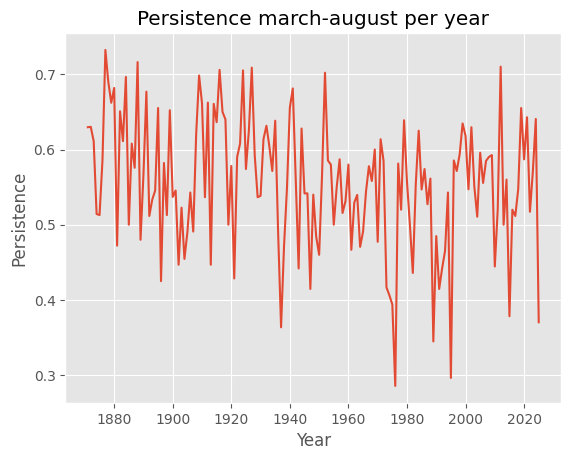

In [ ]:
yearly_pers_winter = (
    df_hot.groupby('year', group_keys=False)
    .apply(lambda group: persistence_count(group, types), include_groups=False)
    .reset_index(name='persistence')
)




In [7]:
pers_count_10_cold = []
avg_between_10_cold = []
avg_len_10_cold = []
total_storm_10_cold = []
decades = []


for i in range(16):
    df_10 = df_cold[(df_cold['year'] < 1870 + 10*(i+1)) & (df_cold['year'] > 1870 +10*i)]
    pers_count_10_cold.append(persistence_count(df_10,types))
    avg_between_10_cold.append(avg_between(df_10,types)[0])
    avg_len_10_cold.append(Total_storms(df_10,types)[0])
    total_storm_10_cold.append(Total_storms(df_10,types)[1])
    decades.append(1870 + 10*i)

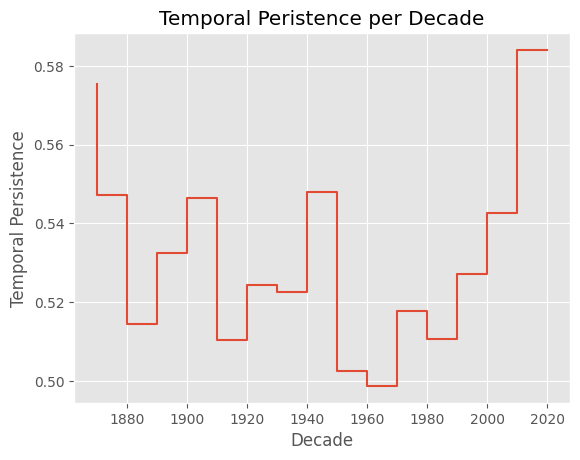

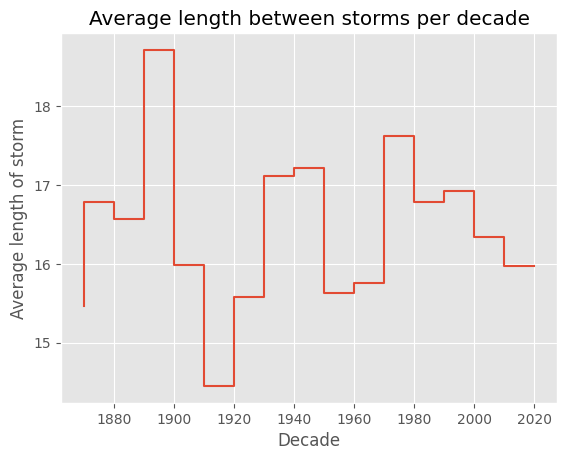

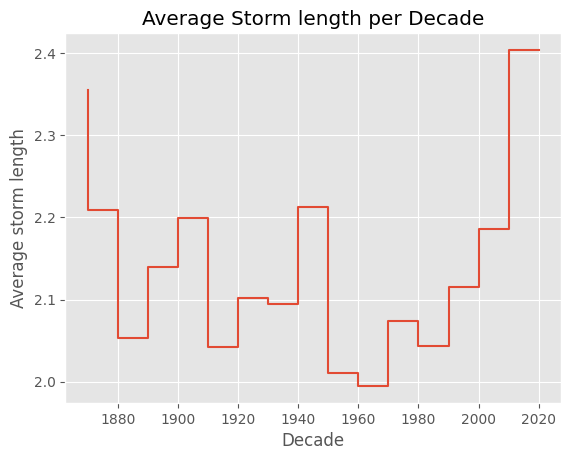

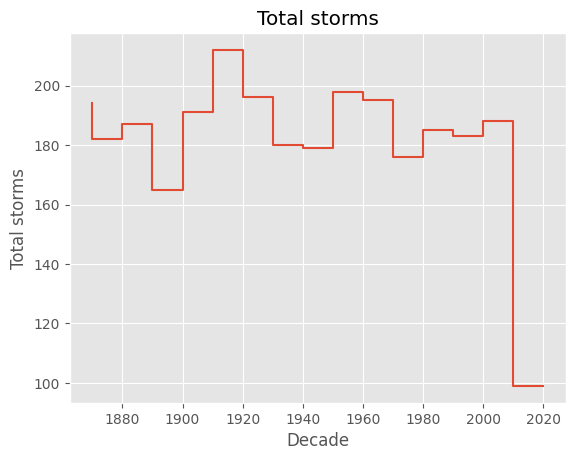

'We are indeed only halfway through the decade, so Total storms for the 2020s is obviously much lower'

In [8]:
df_summary = pd.DataFrame({
    "decade": decades,
    "pers_count": pers_count_10_cold,
    "avg_between": avg_between_10_cold,
    "avg_len": avg_len_10_cold,
    "total_storm": total_storm_10_cold
    
})
df_summary

plt.plot(df_summary['decade'], df_summary['pers_count'],drawstyle = 'steps-pre')
plt.xlabel("Decade")
plt.ylabel("Temporal Persistence")
plt.title("Temporal Peristence per Decade")
plt.grid(True)
plt.show()

plt.plot(df_summary['decade'], df_summary['avg_between'], drawstyle = 'steps-pre')
plt.xlabel("Decade")
plt.ylabel("Average length of storm")
plt.title("Average length between storms per decade")
plt.grid(True)
plt.show()

plt.plot(df_summary['decade'], df_summary['avg_len'], drawstyle = 'steps-pre')
plt.xlabel("Decade")
plt.ylabel("Average storm length")
plt.title("Average Storm length per Decade")
plt.grid(True)
plt.show()

plt.plot(df_summary['decade'], df_summary['total_storm'], drawstyle = 'steps-pre')
plt.xlabel("Decade")
plt.ylabel("Total storms")
plt.title("Total storms")
plt.grid(True)
plt.show()

'''We are indeed only halfway through the decade, so Total storms for the 2020s is obviously much lower'''

 ## To do next:
- continue with more analyses on the data; 
- potentially investigate the use of poisson point processes, homogenous, to model how storms arrive, and then we can estimate the intensity paramater to see how it has changed over time, and even create confidence intervals instead of going through the uncertainty route. Model shouldn't be too much of an approximation. Have a look at the persistence notes to see if we could use a Markov Chain for the De Luca persistence measure. 
- Validate that storms actually line up with cyclonic days.
- examine Jones et al to see if they have any comments on the quality of data pre 1900 - seems to spike before then, curiously.
- Write more up; just methodology for now, not results. 

## Progress and what needs done: 17/10
- continue with more analyses on the data - create a function to find the log likelihood. (not hard)
- point process seems to be worthwhile. issues arise with the discrete time approximation, and the clustering of storms. This can be surpassed, as there are enough days to make the approximation accurate enough and the clustering can be by only looking at only when the storms arrive, and not looking at how long they last. This is declustering, https://doi.org/10.1002/joc.3458 has a good article about this, as well as https://doi.org/10.1016/j.wace.2013.07.003. Seems a valid approach.
- need to properly have a look and validate that storms do line up. Don't know how as of this moment.
- Jones was examined, and no real criticisms of the data were given. Quality of data 'generally good' for mid latitudes.
- Done a fair bit more writing, though now need to write up details about the log likelihood function and MLEs, and confidence intervals.
- Given our De Luca function just finds the MLE for the paramater for a binomial distribution, we can also find confidence intervals for that. Look at stat meth notes, but otherwise these portions are looking promising.

In [9]:
def MLE_QS(df,types):
    '''Returns 95% confidence interval for the QS MLE.'''
    count_1 = 0
    count_2 = 0
    for v in types:
        for i in range(len(df['Grouped_LWT']) - 1):
            if df['Grouped_LWT'].iloc[i] == v and df['Grouped_LWT'].iloc[i + 1] == v:
                count_1 += 1
            if df['Grouped_LWT'].iloc[i]==v:
                count_2 += 1
    if count_2 > 0:
        MLE = count_1/count_2     #            # Probability calculation
        SE =((MLE*(1-MLE))/count_2)**0.5
        zSE = 1.96*SE     # Standard error calculation
        lower = MLE - zSE
        upper = MLE + zSE
        lower = max(0, lower)         # Ensuring logical bounds for our CI
        upper = min(1, upper)

        return [MLE,SE,(lower,upper),count_2]

    else:
        return 0

In [10]:
def MLE_R(df,types):
    '''Returns the MLE,SE,CI, for a data frame that starts on day a and finishes on day t.'''
    t_end = len(df['Grouped_LWT'])
    for v in types:
        num_periods = 0
        lengths = []
        current_len = 0
        for i in range(len(df['Grouped_LWT'])):
            if df['Grouped_LWT'].iloc[i] == v:
                current_len += 1
                # if this is the last row, close out the period
                if i == len(df['Grouped_LWT']) - 1:
                    num_periods += 1
                    lengths.append(current_len)
            else:
                # close out a run if one was active
                if current_len > 0:
                    num_periods += 1               
                    lengths.append(current_len)
                    current_len = 0
    MLE = num_periods/t_end       # MLE calculation
    SE = (MLE/t_end)**0.5
    zSE = 1.96*SE        # Standard Error calculation
    lower = MLE - zSE         # Creating 95% CI
    upper = MLE + zSE
        
    return [MLE, SE, (lower,upper),t_end]

In [11]:
decades = []
MLE_R10 = []
MLE_QS10 = []
SE_R10 = []
SE_QS10 = []



for i in range(16):
    df_10 = df_cold[(df_cold['year'] < 1870 + 10*(i+1)) & (df_cold['year'] > 1870 +10*i)]
    MLE_R10.append(MLE_R(df_10,types)[0])
    MLE_QS10.append(MLE_QS(df_10,types)[0])
    SE_R10.append(MLE_R(df_10,types)[1])
    SE_QS10.append(MLE_QS(df_10,types)[1])
    decades.append(1870 + 10*i)

df_MLE10 = pd.DataFrame({
    "decade": decades,
    "MLE_recurrent": MLE_R10,
    "MLE_Quasi": MLE_QS10,
    "SE_recurrent": SE_R10,
    "SE_Quasi": SE_QS10
})

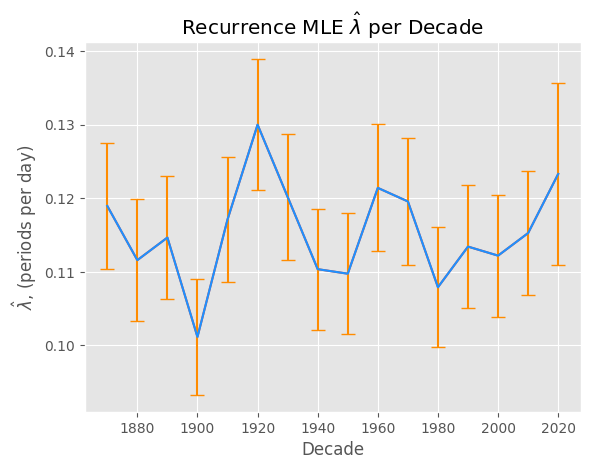

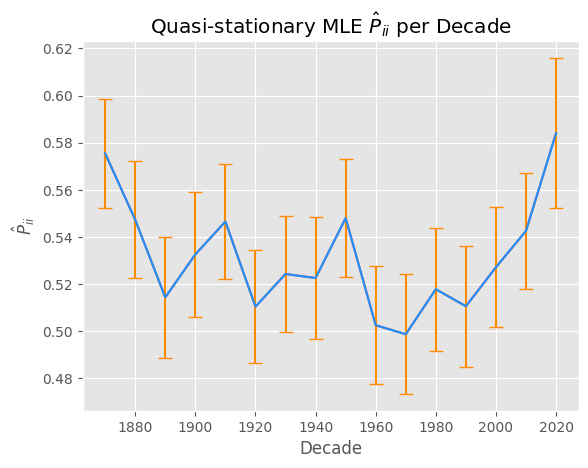

In [12]:
df_MLE10

plt.plot(df_MLE10['decade'], df_MLE10['MLE_recurrent'])
plt.xlabel("Decade")
plt.ylabel(r"$\hat{\lambda}$, (periods per day)")
plt.title(r"Recurrence MLE $\hat{\lambda}$ per Decade")
plt.grid(True)
plt.errorbar(df_MLE10['decade'], df_MLE10['MLE_recurrent'],
             yerr = SE_R10,
             color = 'dodgerblue',
             ecolor ='darkorange',
            capsize = 5)
plt.savefig("MLE_recurrent_per_decade_ColdCyclonic.png", dpi=300, bbox_inches='tight')
plt.show()



plt.plot(df_MLE10['decade'], df_MLE10['MLE_Quasi'])
plt.xlabel("Decade")
plt.ylabel(r"$\hat{P}_{ii}$")
plt.title(r"Quasi-stationary MLE $\hat{P}_{ii}$ per Decade")
plt.errorbar(df_MLE10['decade'], df_MLE10['MLE_Quasi'],
             yerr = SE_QS10,
             color = 'dodgerblue',
             ecolor ='darkorange',
             capsize = 5)
plt.grid(True)
plt.savefig("MLE_Quasi-stationary_per_decade_ColdCyclonic.png", dpi=300, bbox_inches='tight')

plt.show()


## Progress 19/10
- Compare named storms to data still.
- Did more statistics writing, and also took Lambs definitions for the types AC and C from his paper for introduction.
- Wrote about the binomial distribution, somewhat briefly - could maybe go into further depth.
- Created functions to find the two MLEs, that find: MLE, Standard Error, Confidence Interval, and total storm days/total days.
- Standard error seems extremely low for both cases; somewhat curiously given the amount of apparent chaos and variation. 

In [13]:
df_storms = pd.read_csv('metofficestorms.csv')
df_storms['datetime']  =  pd.to_datetime(df_storms[['year','month','day']])
df_storms = df_storms.merge(
    df[['datetime', 'Grouped_LWT']],  # only need the date and value columns
    on='datetime',              # match on the date
    how='left'              # keep all storm rows
)
count = (df_storms['Grouped_LWT'] == 'C').sum()/68

df_storms.to_csv("df_storms_merged.csv", index=False)
print(count)

0.5735294117647058


# MLE plots 

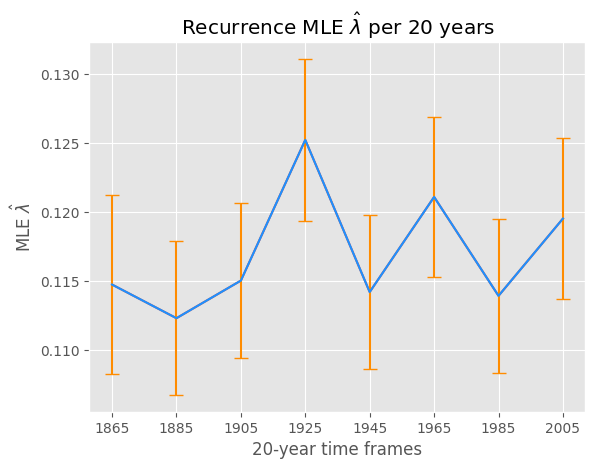

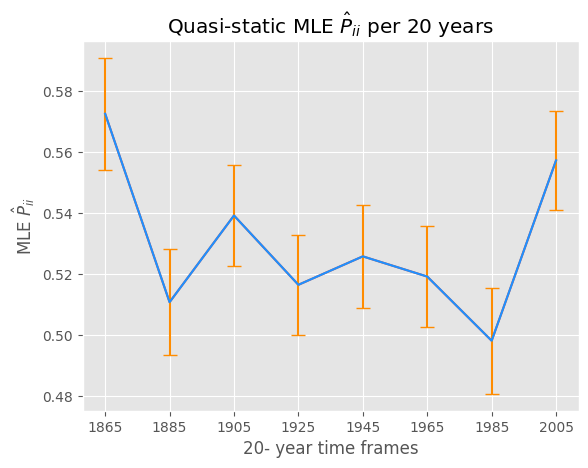

In [14]:
Ys_20 = []
MLE_R20 = []
MLE_QS20 = []
SE_R20 = []
SE_QS20 = []



for i in range(8):
    df_20 = df_cold[(df_cold['year'] <= 1865 + 20*(i+1)) & (df_cold['year'] > 1865 +20*i)]
    MLE_R20.append(MLE_R(df_20,types)[0])
    MLE_QS20.append(MLE_QS(df_20,types)[0])
    SE_R20.append(MLE_R(df_20,types)[1])
    SE_QS20.append(MLE_QS(df_20,types)[1])
    Ys_20.append(f"{1865 + 20*i}")

df_MLE20 = pd.DataFrame({
    "decade": Ys_20,
    "MLE_recurrent": MLE_R20,
    "MLE_Quasi": MLE_QS20,
    "SE_recurrent": SE_R20,
    "SE_Quasi": SE_QS20
})


plt.plot(df_MLE20['decade'], df_MLE20['MLE_recurrent'])
plt.xlabel("20-year time frames")
plt.ylabel(r"MLE $\hat{\lambda}$")
plt.title(r"Recurrence MLE $\hat{\lambda}$ per 20 years")
plt.grid(True)
plt.errorbar(df_MLE20['decade'], df_MLE20['MLE_recurrent'],
             yerr = SE_R20,
             color = 'dodgerblue',
             ecolor ='darkorange',
             capsize = 5) 
plt.show()

plt.plot(df_MLE20['decade'], df_MLE20['MLE_Quasi'])
plt.xlabel("20- year time frames")
plt.ylabel(r"MLE $\hat{P}_{ii}$ ")
plt.title(r"Quasi-static MLE $\hat{P}_{ii}$ per 20 years")
plt.errorbar(df_MLE20['decade'], df_MLE20['MLE_Quasi'],
             yerr = SE_QS20,#
             color = 'dodgerblue',
             ecolor ='darkorange',
             capsize = 5)
plt.grid(True)
plt.show()


In [15]:
decadeshot = []
MLE_R20hot = []
MLE_QS20hot = []
SE_R20hot = []
SE_QS20hot = []

x = {'AC'}

for i in range(8):
    df_10hot = df_hot[(df_hot['year'] > 1865 +20*i) & (df_hot['year'] <= 1865 + 20*(i+1))]
    MLE_R20hot.append(MLE_R(df_10hot,x)[0])
    MLE_QS20hot.append(MLE_QS(df_10hot,x)[0])
    SE_R20hot.append(MLE_R(df_10hot,x)[1])
    SE_QS20hot.append(MLE_QS(df_10hot,x)[1])
    decadeshot.append(f"{1865 + 20*i}")

df_MLE20hot = pd.DataFrame({
    "decade": decadeshot,
    "MLE_recurrent": MLE_R20hot,
    "MLE_Quasi": MLE_QS20hot,
    "SE_recurrent": SE_R20hot,
    "SE_Quasi": SE_QS20hot
})
df_MLE20hot



,decade,MLE_recurrent,MLE_Quasi,SE_recurrent,SE_Quasi
0,1865,0.116304,0.655949,0.006491,0.015553
1,1885,0.125815,0.646248,0.005847,0.013231
2,1905,0.120380,0.627004,0.005719,0.014048
3,1925,0.118207,0.651406,0.005668,0.013505
4,1945,0.126359,0.664017,0.005860,0.012696
5,1965,0.124728,0.674237,0.005822,0.012485
6,1985,0.137500,0.625463,0.006113,0.013168
7,2005,0.131793,0.630617,0.005984,0.013320


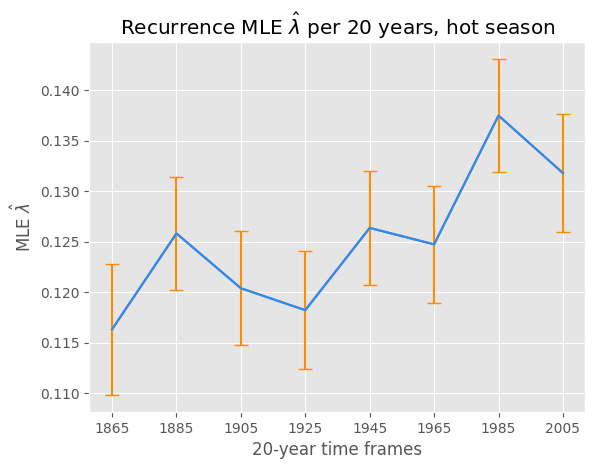

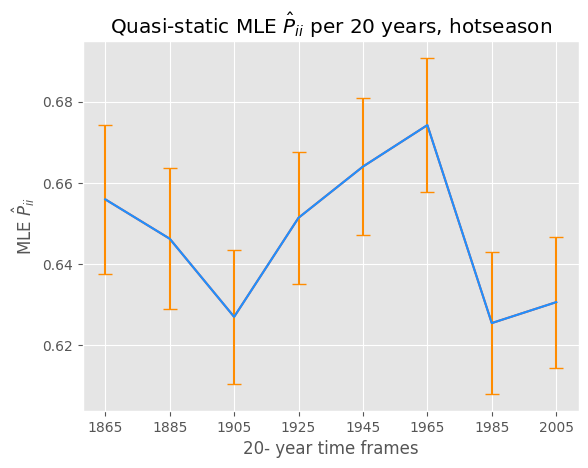

In [16]:
plt.plot(df_MLE20hot['decade'], df_MLE20hot['MLE_recurrent'])
plt.xlabel("20-year time frames")
plt.ylabel(r"MLE $\hat{\lambda}$")
plt.title(r"Recurrence MLE $\hat{\lambda}$ per 20 years, hot season")
plt.grid(True)
plt.errorbar(df_MLE20hot['decade'], df_MLE20hot['MLE_recurrent'],
             yerr = SE_R20,
             color = 'dodgerblue',
             ecolor ='darkorange',
             capsize = 5) 
plt.show()

plt.plot(df_MLE20hot['decade'], df_MLE20hot['MLE_Quasi'])
plt.xlabel("20- year time frames")
plt.ylabel(r"MLE $\hat{P}_{ii}$ ")
plt.title(r"Quasi-static MLE $\hat{P}_{ii}$ per 20 years, hotseason")
plt.errorbar(df_MLE20hot['decade'], df_MLE20hot['MLE_Quasi'],
             yerr = SE_QS20,#
             color = 'dodgerblue',
             ecolor ='darkorange',
             capsize = 5)
plt.grid(True)
plt.show()

### Transition matrix

Next, going to have a look at the full markov transition matrix, under the assumption that the weather has Markov property. Can talk with simon about whether this assumption is valid. 

In [17]:
def persistence_matrix(df, types):
    """
    Calculates the conditional transition probabilities P_ij = P(d_{t+1}=j | d_t=i)
    for all grouped weather types given in 'types'.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a column 'Grouped_LWT' with daily weather types.
    types : list
        List of unique grouped weather types, e.g. ['AC', 'C', 'N'].

    Returns
    -------
    pandas.DataFrame
        Transition probability matrix (rows = from-type i, columns = to-type j).
    """
    # Initialize a count matrix
    count_matrix = pd.DataFrame(0, index=types, columns=types, dtype=float)

    # Count transitions only if from_type is in types
    for i in range(len(df['Grouped_LWT']) - 1):
        from_type = df['Grouped_LWT'].iloc[i]
        to_type = df['Grouped_LWT'].iloc[i + 1]
        if from_type in types:
            if to_type in types:
                count_matrix.at[from_type, to_type] += 1

    # Denominator: number of times day t is in types (excluding last day)
    total_from = {t: ((df['Grouped_LWT'].iloc[:-1] == t)).sum() for t in types}

    # Convert counts to probabilities
    prob_matrix = count_matrix.copy()
    for t in types:
        if total_from[t] > 0:
            prob_matrix.loc[t, :] /= total_from[t]
        else:
            prob_matrix.loc[t, :] = 0

    return prob_matrix




In [18]:
p_array = persistence_matrix(df, ['AC', 'C', 'N'])

p_array


,AC,C,N
AC,0.633290,0.058284,0.308426
C,0.103789,0.552169,0.344042
N,0.245410,0.238347,0.516243


Persistence matrix crafted, with all transition probabilities. Works well. Next going to look at steady state solutions.

In [19]:
import numpy as np

p_df = persistence_matrix(df_cold, ['AC', 'C', 'N'])

p_array = p_df.to_numpy()


In [20]:
eigvals, eigvecs = np.linalg.eig(p_array.T)
steady_state = np.real(eigvecs[:, np.isclose(eigvals, 1)])
steady_state = steady_state / steady_state.sum()  # Normalize
steady_state = steady_state.flatten()
steady_state

array([0.32712851, 0.2487763 , 0.42409518])

## Progress 26/10
- To examine whether or not our MLE changes, we can let $\log[\frac{\hat{P}_{ii}^{(t)}}{1-\hat{P}_{ii}^{(t)}}] = \beta_0 +\beta_1t+ \epsilon_t$. Can choose a certain timeframe to look at this over. (binomial regression) https://timeseriesreasoning.com/contents/binomial-regression-model/
 but may be an interesting approach. For recurrence, we may use poisson regression.
- Tranisition matrix created, for AC,C,N, steady state solution found. potentially could be mentioned briefly. 
- De Luca found the NCEP and 20CR disagree about persistence of Anticyclonic types in summer. Mention this. (NCEP $\approx$ 0.5, 20CR $\approx$ 0.65), over the 80s
-  ``(i) 20CR overestimates cloud fraction and precipitation [https://www.tandfonline.com/doi/abs/10.1080/01621459.1968.10480934]; and (ii) NCEP underestimates the temperature, overestimates the wind-speed and monthly precipitation variability [https://doi.org/10.1175/JCLI-D-11-00004.1]."
- Turns out than when examined for 20 year period, more interesting data for summer anticyclonic MLE shows; Recurrrence shows patterns.
- 



In [21]:
print(MLE_QS(df_hot,{'AC'}))
print(MLE_QS(df_cold,{'C'}))

[0.6469542896633429, 0.0047486371121511104, (0.6376469609235267, 0.6562616184031591), 10129]
[0.5296567571449088, 0.005981450535068231, (0.517933114096175, 0.5413804001936425), 6963]


https://climexp.knmi.nl/start.cgi?id=someone@somewhere climate temperature data, for potentially using the daily average temperature to use for covariates with ourgeneralised linear models. Now, also going to look at anti-cyclonic quasi-stationary persistence over 30 years, instead of 20. Data seemed chaotic for 20, so just wanting to wsee if there are any potential trends. 

In [22]:
thirtyhot = []
MLE_R30hot = []
MLE_QS30hot = []
SE_R30hot = []
SE_QS30hot = []

x = {'AC'}

for i in range(5):
    df_30hot = df_hot[(df_hot['year'] < 1870 + 30*(i+1)) & (df_hot['year'] > 1870 +30*i)]
    MLE_R30hot.append(MLE_R(df_30hot,x)[0])
    MLE_QS30hot.append(MLE_QS(df_30hot,x)[0])
    SE_R30hot.append(MLE_R(df_30hot,x)[1])
    SE_QS30hot.append(MLE_QS(df_30hot,x)[1])
    thirtyhot.append(1870 + 30*i)

df_MLE30hot = pd.DataFrame({
    "decade": thirtyhot,
    "MLE_recurrent": MLE_R30hot,
    "MLE_Quasi": MLE_QS30hot,
    "SE_recurrent": SE_R30hot,
    "SE_Quasi": SE_QS30hot
}
)

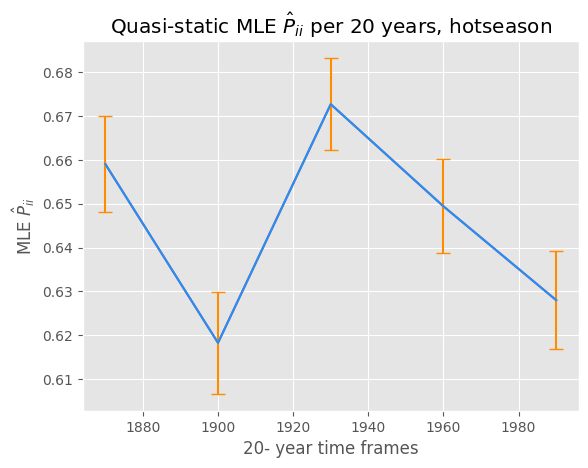

In [23]:


plt.plot(df_MLE30hot['decade'], df_MLE30hot['MLE_Quasi'])
plt.xlabel("20- year time frames")
plt.ylabel(r"MLE $\hat{P}_{ii}$ ")
plt.title(r"Quasi-static MLE $\hat{P}_{ii}$ per 20 years, hotseason")
plt.errorbar(df_MLE30hot['decade'], df_MLE30hot['MLE_Quasi'],
             yerr = SE_QS30hot,#
             color = 'dodgerblue',
             ecolor ='darkorange',
             capsize = 5)
plt.grid(True)
plt.show()

Little pattern appears. We now look at generalised linear regression models for poisson and binomial - logarithmic and logistic link.

In [24]:
def logit(x):
    return np.log(x / (1 - x))

def log(x):
    return np.log(x)

df_MLE20['logit_pers'] = df_MLE20['MLE_Quasi'].apply(logit)
df_MLE20['log_rec'] = df_MLE20['MLE_recurrent'].apply(log)

df_MLE20hot['logit_pers'] = df_MLE20hot['MLE_Quasi'].apply(logit)
df_MLE20hot['log_rec'] = df_MLE20hot['MLE_recurrent'].apply(log)

In [25]:
from sklearn.linear_model import LinearRegression


In [26]:
df_MLE20

,decade,MLE_recurrent,MLE_Quasi,SE_recurrent,SE_Quasi,logit_pers,log_rec
0,1865,0.114748,0.572603,0.006496,0.018310,0.292478,-2.165016
1,1885,0.112307,0.510817,0.005567,0.017330,0.043276,-2.186520
2,1905,0.115034,0.539227,0.005633,0.016569,0.157229,-2.162523
3,1925,0.125241,0.516507,0.005878,0.016308,0.066052,-2.077512
4,1945,0.114207,0.525832,0.005613,0.016919,0.103422,-2.169744
5,1965,0.121103,0.519210,0.005780,0.016554,0.076876,-2.111110
6,1985,0.113931,0.498173,0.005606,0.017450,-0.007308,-2.172162
7,2005,0.119534,0.557308,0.005826,0.016107,0.230244,-2.124151


coefficient of determination: 0.0672858734332743
intercept: 0.15746062784927245
slope: [-0.0005311]


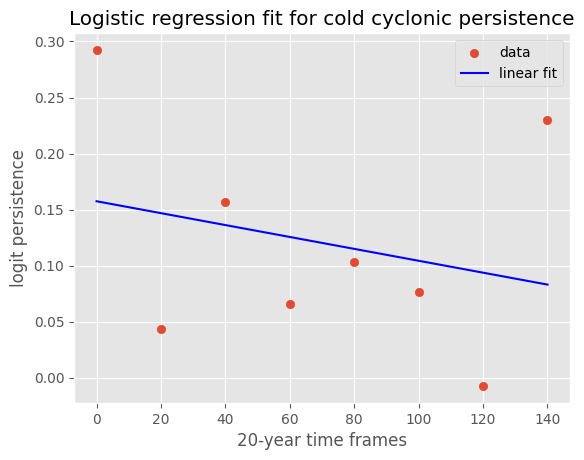

In [27]:
y = df_MLE20['logit_pers'].values
X = np.array([0,20,40,60,80,100,120,140]).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

plt.scatter(X, y, label='data')
plt.plot(X, model.predict(X), color='blue', label='linear fit')
plt.xlabel("20-year time frames")
plt.ylabel("logit persistence")
plt.title("Logistic regression fit for cold cyclonic persistence")
plt.legend()
plt.grid(True)
plt.show()